# Synapses

So far, we've created neurons but we haven't actually connected them with each other. We're going to now add a model of *synapses* that connect neurons together.

We use the term "pre-synaptic" to refer to the neuron that is "sending" the spike and "post-synaptic" to refer to the neuron that is receiving the spike. Many pre-synaptic neurons might connect to a single post-synaptic neuron. Post-synaptic neurons can also connect back to pre-synaptic neurons, forming loops.

## Synaptic Models
Thusfar, we have been modeling spikes as binary "on" or "off" signals. However, there are some problems with this. First, it is not a realistic representation of how neurons transmit data. Action potentials are not binary; they instead consist of a continuous rise and lowering of potential energy. But biological realism is not the only problem with binary spike outputs. The second problem is that in binary representations of spikes, there is no "memory"---the history of a neuron's firing does not tell us anything about its current state.

So when we connect neurons, rather than sending data between neurons with binary spikes, we will pass these binary spikes through a **synaptic model** that moderates communication between neurons.

## Decaying Synaptic Model

A common synaptic model uses simple exponential decay. We will call our synaptic model function $g(t)$. Our synaptic model behaves very similar to [our LIF model](05%20-%20Implementing%20Firing.ipynb), except that rather than the output being binary (spike or no spike), the output will be the potential itself (a number). Our synaptic potential will start at $g(0) = 0$. Whenever there is a spike, $g(t)$ will instantaneously increment by the spike's potential. Otherwise, it will have a rate of change $g'(t)$:

$$g'(t) = -\frac{1}{\tau_s}g(t)$$

This is analogous to the equation we had for $v'(t)$ for LIF neurons {eq}`eq:vprime`, except with no incoming current. $\tau_s$ is a constant that determines how quickly the potential decays back to $0$. This is very similar to our definition of $v'(t)$ for LIF neurons, with $\tau_{s}$ instead of $\tau_{rc}$. And [just like we did for our LIF neurons](ssec:discrete-time-lif) {eq}`eq:vdiscrete`, we can approximate its value as:

$$
\begin{align}
g[0] &= 0 \\
g[t] &= g[t-1] (1 - \frac{T_{step}}{\tau_s}) + \frac{T_{step}}{\tau_{s}}\delta_s[t]
\end{align}
$$(eq:gdiscrete)

Where $\delta_s[t]$ represents the potential of any incoming spikes (or $0$ if there are no incoming spikes) and $T_{step}$ represents the size of our time steps. If we plot this out with a spike at time `0`, we can see that it decays exponentially:

In [9]:
import matplotlib.pyplot as plt
import numpy as np

tau_s = 0.01
t_step = 0.001

times = np.arange(-0.01, 0.1, t_step)

def isZero(t): return abs(t) < t_step / 2 # check if t is close to zero

g = 0
g_values = []
for t in times:
    if isZero(t): spike_input = 1 / t_step # Spike input at t = 0
    else:         spike_input = 0

    g = g * (1 - t_step / tau_s) + spike_input * t_step / tau_s
    g_values.append(g)

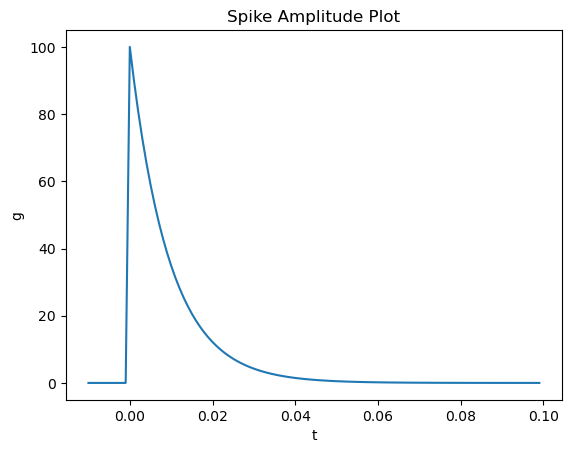

In [10]:
plt.figure()
plt.plot(times, g_values)
plt.xlabel('t')
plt.ylabel('g')
plt.title('Spike Amplitude Plot')
plt.show()

You might also notice the y-scale shifting as we modify $\tau_s$. That is because our synapse is delivering the same total "potential" to the postsynaptic neuron regardless of the value of $\tau_s$. However, for larger values of $\tau_s$, it is spreading that potential out further over time.

To put it another way, if we plotted the area under our curve (which represents the total potential delivered to the post-synaptic neuron), our sum will stay approximately the same. Below, we take the sum of the area of bars and our sum should always come out to $\approx 1$:

Try out different values of `tau_s` in the code below and see how it affects the decay of the synaptic potential.


```{editor} python
:packages: matplotlib,numpy
:run_on_load: true
:max_height: 500px

import matplotlib.pyplot as plt
import numpy as np

tau_s  = 0.050 # <-SLIDE(0.010 to 0.04 by 0.001)
t_step = 0.005 # <-SLIDE(0.001 to 0.01 by 0.001)

times = np.arange(0, 0.25, t_step)

def isZero(t): return abs(t) < t_step / 2 # check if t is close to zero

areaUnderCurve = 0
g = 0
g_values = []
for t in times:
    if isZero(t): spike_input = 1 / t_step # Spike input at t = 0
    else:         spike_input = 0

    g = g * (1 - t_step / tau_s) + spike_input * t_step / tau_s
    g_values.append(g)

    areaUnderCurve += g * t_step

# Plot the data
plt.figure()
plt.plot(times, g_values)
plt.bar(times, g_values, color='black', edgecolor="#999", width=t_step)
plt.xlabel('t')
plt.ylabel('g')
plt.show()

print(f"Area under curve: {areaUnderCurve}")
```

## Connecting LIFs with PSPs

Now, let's connect our LIF neurons from before with these decaying synaptic models. Let's start with our existing `FirstOrderLIF` class:


In [11]:
class FirstOrderLIF: # First Order Leaky Integrate and Fire
    def __init__(self, tau_rc=0.2, tau_ref=0.002, v_init=0, v_th=1):
        self.tau_rc  = tau_rc  # Potential decay time constant
        self.v       = v_init  # Potential value
        self.v_th    = v_th    # Firing threshold
        self.tau_ref = tau_ref # Refractory period time constant

        self.output          = 0 # Current output value
        self.refractory_time = 0 # Current refractory period time (how long until the neuron can fire again)
    
    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time

        if self.refractory_time < 0: # If the neuron is not in its refractory period
            self.v = self.v * (1 - t_step / self.tau_rc) + I * t_step / self.tau_rc # Integrate the input current
        
        if self.v > self.v_th: # If the potential is above the threshold
            self.refractory_time = self.tau_ref # Enter the refractory period
            self.output = 1 / t_step            # Emit a spike
            self.v = 0                          # Reset the potential
        else: # If the potential is below the threshold
            self.output = 0 # Do not fire
        
        return self.output


We will create a class `FirstOrderSynapse` to represent the Post-Synaptic Potential (PSP) or a synapse. Our `FirstOrderSynapse` class will have two instance variables:

- `output` --- a number representing the output potential of the synapse
- `tau_s` --- a number representing the decay rate of the synapse (default: `0.01`)

It will also have one method:

- `step(I, t_step)` --- a function that advances our neuron and synaptic model by one time step. It will take two arguments: (1) `I`, the input potential from the pre-synaptic neuron and (2) `t_step`, the size of our time step. It will return the output potential of the synapse.

At every step, we will update our synapse output using the formula above {eq}`eq:gdiscrete`:

```python
self.output = self.output * (1 - t_step / self.tau_s) + I * t_step / self.tau_s
```

In [27]:
class FirstOrderSynapse:
    def __init__(self, tau_s=0.01):
        self.tau_s  = tau_s # Synaptic time constant
        self.output = 0     # Current potential

    def step(self, I, t_step):
        self.output = self.output * (1 - t_step / self.tau_s) + I * t_step / self.tau_s # Decay potential
        return self.output

Then, if we create a neuron (`neuron`) and synapse (`synapse`), we can define a `combinedStep` function that will advance both the neuron and synapse by one time step:

In [28]:
neuron  = FirstOrderLIF(tau_rc=0.02, tau_ref=0.2)
synapse = FirstOrderSynapse(tau_s=0.2)

def combinedStep(I, t_step):
    neuron_output  = neuron.step(I, t_step)
    synapse_output = synapse.step(neuron_output, t_step)
    return synapse_output

In [29]:
T_step = 0.001
times  = np.arange(0, 2, T_step)
I      = 2 # Input current

output_history = []

for _ in times:
    output = combinedStep(I, T_step)
    output_history.append(output)

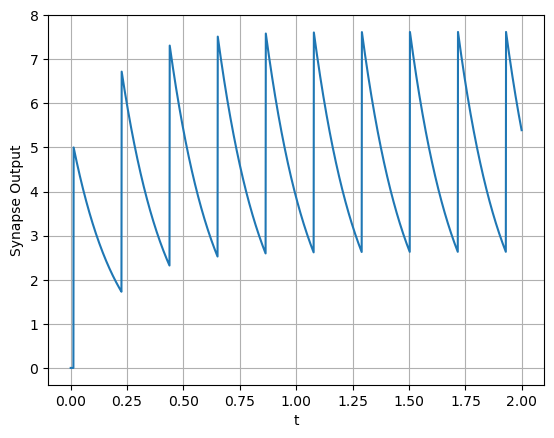

In [31]:
plt.figure()
plt.plot(times, output_history)
plt.xlabel('t')
plt.ylabel('Synapse Output')
plt.grid(True)
plt.show()

The above plot shows that our value of $\tau_s$, our neuron fires before the synapse's output has fully decayed. Let's increase $\tau_s$ and zoom out:

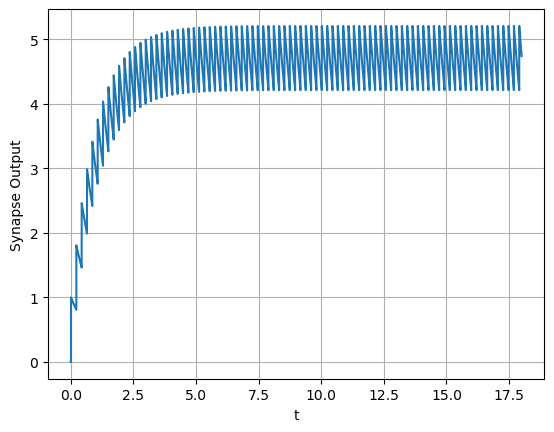

In [41]:
neuron  = FirstOrderLIF(tau_rc=0.02, tau_ref=0.2)
synapse = FirstOrderSynapse(tau_s=1.0)

def combinedStep(I, t_step):
    neuron_output  = neuron.step(I, t_step)
    synapse_output = synapse.step(neuron_output, t_step)
    return synapse_output

T_step = 0.001
times  = np.arange(0, 18, T_step)
I      = 2 # Input current

output_history = []

for _ in times:
    output = combinedStep(I, T_step)
    output_history.append(output)

plt.figure()
plt.plot(times, output_history)
plt.xlabel('t')
plt.ylabel('Synapse Output')
plt.grid(True)
plt.show()


Now, we can see that our output reaches and "hovers" around a steady state for a constant input.



## Summary

- Neurons communicate through a synapse model
- Most synapse models "convert" binary spikes into smoother potentials that decay over time
- We use a synapse model whose rate of change $g'(t) = -\frac{1}{\tau_s}g(t)$ and increments every time there is a spike
  -  $\tau_s$ determines the rate of decay back to $0$
- We can model our synapse in discrete time steps using:
  - $g[0] = 0$
  - $g[t+1] = g[t] (1 - \frac{T_{step}}{\tau_s}) + \frac{T_{step}}{\tau_s}\delta_s[t]$
    - $\delta_s(t)$ is the energy coming from incoming spikes ($0$ if there are no spikes at time $t$)